In [ ]:
import numpy as np
import torch
from torch import nn, optim, save
from torch.nn import functional as F
from torchvision import datasets
from torchvision.utils import make_grid
from torch.nn import Module, Sequential, Linear, ReLU, Sigmoid, Dropout, Tanh
from torch import Tensor, randn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

from torch import ones, zeros
from torch.autograd import Variable

from torch.nn import BCELoss
from google.colab import drive

from collections import defaultdict, deque
import datetime
import pickle
import time

import torch
import torch.distributed as dist

import errno
import os

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import json

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip -P "*****" "/content/drive/MyDrive/master/an2/sri/data/validation.zip" -d "/content/"

In [ ]:
base_path = r"/content/validation/"
annos_path = base_path + r"/annos"
images_path = base_path + r"/image"

In [ ]:
class ClothesDetectionDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.annos = list(sorted(os.listdir(os.path.join(root, "annos"))))
        self.imgs = list(sorted(os.listdir(os.path.join(root, "image"))))

    def __getitem__(self, idx):
        # load images ad masks

        img_path = os.path.join(self.root, "image", self.imgs[idx])
        annos_path = os.path.join(self.root, "annos", self.annos[idx])

        img = Image.open(img_path).convert("RGB")

        num_objs = 0
        boxes = []
        labels = []

        with open(annos_path) as json_file:
            data = json.load(json_file)

            for item in data.keys():
                if item.startswith("item"):
                    num_objs += 1

                    boxes.append(data[item]["bounding_box"])
                    labels.append(data[item]["category_id"]%13)

        # print(self.annos[idx], self.imgs[idx], boxes, labels, idx, img.size)
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
           img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 13197 (delta 76), reused 42 (delta 13), pack-reused 13056
Receiving objects: 100% (13197/13197), 15.52 MiB | 11.69 MiB/s, done.
Resolving deltas: 100% (9182/9182), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = ClothesDetectionDataset(base_path, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)
# For Training
print("here")
images,targets = next(iter(data_loader))

images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
print(len(images), len(targets))
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  

In [ ]:
import math
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device", device)


num_classes = 13

dataset = ClothesDetectionDataset(base_path, get_transform(train=True))
dataset_test = ClothesDetectionDataset(base_path, get_transform(train=False))


indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-500])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-500:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=1,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=1,
    collate_fn=utils.collate_fn)

device cuda


In [ ]:
from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import utils


def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    hlosses = {}

    hlosses["loss"] = []
    hlosses['loss_classifier'] = []
    hlosses['loss_box_reg'] = []

    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)
    count = 0
    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()
            
        # print("ce avem noi aici = ", metric_logger.meters['loss'].median())
        count += 1

        if count == 10:
            count = 0
            # print("average = ", sum(losses_count) / len(losses_count) )
            # print("metrics = ", metric_logger.meters['loss'].median, metric_logger.meters['loss_classifier'].median, metric_logger.meters['loss_box_reg'].median)
            hlosses['loss'].append(metric_logger.meters['loss'].median)
            hlosses['loss_classifier'].append(metric_logger.meters['loss_classifier'].median)
            hlosses['loss_box_reg'].append(metric_logger.meters['loss_box_reg'].median)
        
        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return hlosses

In [ ]:

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

num_epochs = 5
metrics = []
ghlosses = {}

ghlosses["loss"] = []
ghlosses['loss_classifier'] = []
ghlosses['loss_box_reg'] = []

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    metriclogger = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    ghlosses['loss'] += metriclogger['loss']
    ghlosses['loss_classifier'] += metriclogger['loss_classifier']
    ghlosses['loss_box_reg'] += metriclogger['loss_box_reg']
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    

print("That's it!")

In [ ]:
from engine import train_one_epoch, evaluate

evaluate(model, data_loader_test, device=device)

creating index...
index created!
Test:  [  0/500]  eta: 0:01:29  model_time: 0.0589 (0.0589)  evaluator_time: 0.0268 (0.0268)  time: 0.1781  data: 0.0891  max mem: 8962
Test:  [100/500]  eta: 0:00:24  model_time: 0.0446 (0.0442)  evaluator_time: 0.0098 (0.0102)  time: 0.0588  data: 0.0036  max mem: 8962
Test:  [200/500]  eta: 0:00:18  model_time: 0.0445 (0.0441)  evaluator_time: 0.0097 (0.0099)  time: 0.0590  data: 0.0034  max mem: 8962
Test:  [300/500]  eta: 0:00:11  model_time: 0.0426 (0.0438)  evaluator_time: 0.0100 (0.0099)  time: 0.0577  data: 0.0033  max mem: 8962
Test:  [400/500]  eta: 0:00:05  model_time: 0.0446 (0.0436)  evaluator_time: 0.0099 (0.0099)  time: 0.0588  data: 0.0034  max mem: 8962
Test:  [499/500]  eta: 0:00:00  model_time: 0.0450 (0.0436)  evaluator_time: 0.0092 (0.0099)  time: 0.0596  data: 0.0032  max mem: 8962
Test: Total time: 0:00:29 (0.0596 s / it)
Averaged stats: model_time: 0.0450 (0.0436)  evaluator_time: 0.0092 (0.0099)
Accumulating evaluation results.

In [ ]:
from matplotlib import pyplot as plt
import pylab as pl
from IPython import display

def plot_losses(loss_list): 
    display.display(pl.gcf())   
    pl.plot(range(len(loss_list)), loss_list, c='b')
    time.sleep(1.0)

<Figure size 432x288 with 0 Axes>

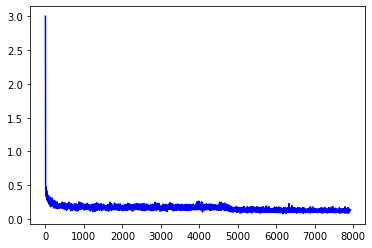

In [ ]:
plot_losses(ghlosses['loss'])

<Figure size 432x288 with 0 Axes>

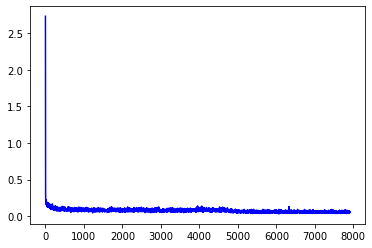

In [ ]:
plot_losses(ghlosses['loss_classifier'])

<Figure size 432x288 with 0 Axes>

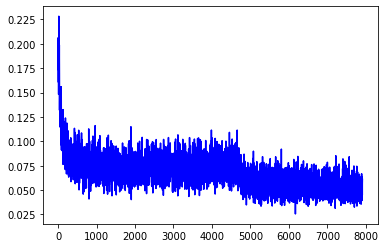

In [ ]:
plot_losses(ghlosses['loss_box_reg'])

In [ ]:
PATH = "state_dict_model_1.pt"

torch.save(model.state_dict(), r"/content/drive/MyDrive/master/an2/sri/data/"+PATH)

In [ ]:
import math
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
num_classes = 13

PATH = r"/content/drive/MyDrive/master/an2/sri/data/"+r"state_dict_model_1.pt"
_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = _model.roi_heads.box_predictor.cls_score.in_features
_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
image_id = 27

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device", device)
dataset_test = ClothesDetectionDataset(base_path, get_transform(train=False))

_model.to(device)

img, _ = dataset_test[image_id]
_model.eval()
with torch.no_grad():
    prediction = _model([img.to(device)])

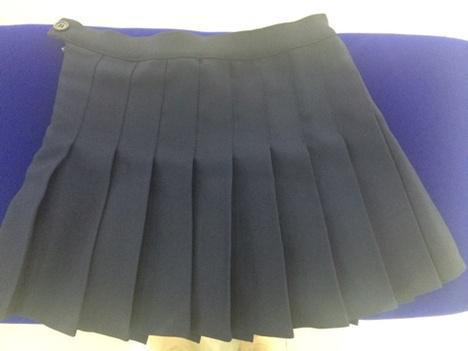

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [ ]:
categories = {
    1: "short sleeve top",
    2: "long sleeve top",
    3: "short sleeve outwear",
    4: "long sleeve outwear",
    5: "vest",
    6: "sling",
    7: "shorts",
    8: "trousers",
    9: "skirt",
    10: "short sleeve dress",
    11: "long sleeve dress",
    12: "vest dress",
    0: "sling dress"              
}
categories[1]
prediction

[{'boxes': tensor([[  1.5673,  18.9173, 417.6489, 349.6527],
          [  1.3828,  24.8372, 362.7806, 351.0000],
          [208.2292,  44.0367, 468.0000, 321.8389]], device='cuda:0'),
  'labels': tensor([9, 7, 9], device='cuda:0'),
  'scores': tensor([0.9621, 0.0599, 0.0593], device='cuda:0')}]

In [ ]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
img, _ = dataset_test[image_id]
boxes = prediction[0]['boxes'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

_img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
draw = ImageDraw.Draw(_img)
idx = 0

for box in boxes:
    
    if scores[idx] > 0.5:
        draw.rectangle(((box[0], box[1]), (box[2], box[3])))
        draw.text((box[0], box[1]), categories[labels[idx]],  fill=(255,255,255,255))

    idx+=1

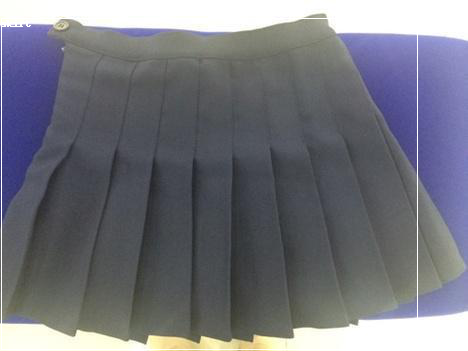

In [ ]:
_img